In [1]:
import json
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
with open('../data/raw/raw2.json') as data_file:    
    data = json.load(data_file)

In [34]:
responses = [r['doc'] for r in data['rows']]

In [35]:
df = pd.DataFrame(responses)

In [36]:
df.loc[:, 'startedAt'] = pd.to_datetime(df.startedAt)
df.loc[:, 'completedAt'] = pd.to_datetime(df.completedAt)
df.loc[:, 'duration'] = (df.completedAt - df.startedAt)
df.loc[:, 'durationSeconds'] = df.duration.apply(lambda d: d.total_seconds())

In [37]:
## Event counts for each question
events = list(df.events)
combined_events = list(itertools.chain(*events))
eventsdf = pd.DataFrame(combined_events)

In [38]:
# Moved slider event count
survey_events = eventsdf[eventsdf.type == 'Moved Slider']
event_counts = (survey_events
    .groupby(['sessionId', 'question'])
    ._id.agg('count')
    .unstack()
    .reset_index()
    .fillna(0))

In [39]:
event_counts.columns = [
    'sessionId', 'ev0', 'ev1', 
    'ev2', 'ev3', 'ev4', 'ev5'
]

In [40]:
with_event_counts = pd.merge(
    df, 
    event_counts, 
    left_on='_id', 
    right_on='sessionId', 
    how='left'
)

In [41]:
# Instruction counts for each question
instruction = eventsdf[eventsdf.type != 'Moved Slider']
instruction_count = (instruction
    .groupby(['sessionId', 'question'])
    ._id.agg('count')
    .unstack()
    .reset_index()
    .fillna(0))

In [42]:
instruction_count.columns = [
    'sessionId', 'i0', 'i1', 
    'i2', 'i3', 'i4', 'i5'
]

In [43]:
with_instruction_count = pd.merge(
    with_event_counts, 
    instruction_count,
    left_on='_id', 
    right_on='sessionId', 
    how='left'
)

In [44]:
## Answers for each question
answers = list(df.answers)
combined_answers = list(itertools.chain(*answers))
adf = pd.DataFrame(combined_answers)

In [45]:
mean_times = adf.groupby('sessionId').resonseTime.agg('mean')

In [46]:
rtdf = adf[['sessionId', 'question', 'resonseTime']]

In [47]:
svo = rtdf[rtdf.question < 6]

In [48]:
svo.groupby('question').resonseTime.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
question,,,,,,,,
0,849.0,18413.128386,22023.935269,105.0,8084.00,13401.0,21364.00,314691.0
1,842.0,11909.523753,9461.242972,389.0,5216.50,9405.0,15249.25,62125.0
2,844.0,7999.302133,9254.703139,149.0,3705.50,6041.5,9975.00,205726.0
3,843.0,9398.085409,11791.422250,16.0,3720.50,7232.0,12242.00,243804.0
4,843.0,4474.065243,4206.101205,16.0,2021.00,3237.0,5570.00,62669.0
5,844.0,6267.755924,6669.454095,5.0,2861.25,4672.0,7637.75,89398.0


In [49]:
svo['responseSec'] = svo.resonseTime / 1000

/Users/pdarche/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


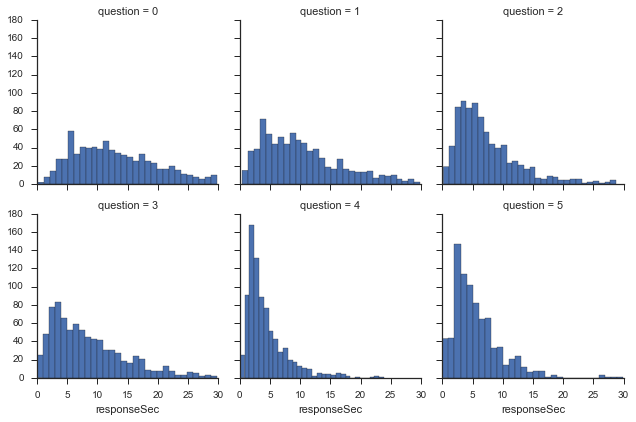

In [50]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(svo[svo.responseSec < 30], col="question", col_wrap=3)
g = g.map(plt.hist, "responseSec", bins=30)

In [51]:
# rtdf.pivot_table(index='sessionId', values=['question', 'resonseTime'])
# rtdf.pivot_table(index='sessionId', columns=['question', 'resonseTime'])
rows = []
for name, group in svo.groupby('sessionId'):
    res = group.resonseTime.transpose()
    row = [name] + list(res)
    if len(row) == 7:
        rows.append(row)

In [52]:
timedf = pd.DataFrame(data=rows, columns=['sessionId', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5'])

### Look for responses that were too quick
Thought process: I'm looking for people who were just clcking the buttons and not moving on.  Once way of determining that is to see how long they took to answer each question.  I could see if the were going that across the board (just clicking for all answers) or if they were taking very little time on any one answer.

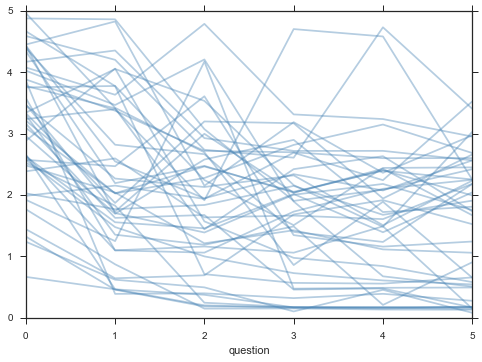

In [53]:
fig, ax = plt.subplots(1, 1)
# svo.groupby('sessionId').plot.line(x='question', y='responseSec', ax=ax, alpha=0.7)
bad_sessions = []
for name, group in svo.groupby('sessionId'):
    if (group.responseSec < 5).all():
        group.plot(x='question', y='responseSec', ax=ax, alpha=0.4, legend=False, color='steelblue')
        bad_sessions.append(name)

In [54]:
bdf = df[df._id.isin(bad_sessions)]
bdf.shape

(44, 16)

In [55]:
import pickle

In [56]:
df.shape

(850, 16)

In [68]:
with open('./bad_data.pickle', 'wb') as f:
    pickle.dump(bdf, f)

/Users/pdarche/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


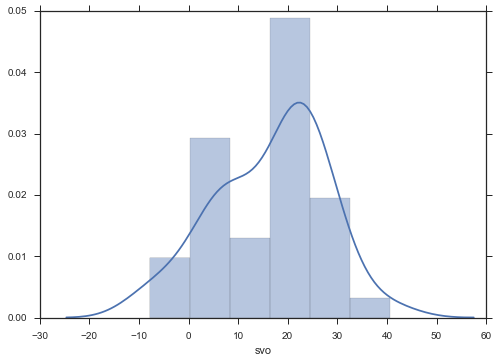

In [26]:
sns.distplot(bdf[bdf.svo.notnull()].svo)

In [260]:
# svo.groupby('sessionId').get_group('00df99c23deb47a45ff5f4a80df687b0').responseSec.transpose()

### Review the events
Thinking: I'm looking to see if there are any patterns in the events that would indicate whether or not the person was taking the question seriously.  It could be the case that they didn't move the slider at all and just clicked through, or it could be that they just moved it to one place very quickly

In [296]:
eventsdf.loc[:, 'occuredAt'] = eventsdf.occuredAt.apply(pd.to_datetime)

In [343]:
eventsdf.loc[:, 'selfDiff'] = (test.self - test.selfStart)
eventsdf.loc[:, 'diffSum'] = eventsdf.groupby('question').selfDiff.cumsum()
eventsdf.loc[:, 'otherDiff'] = (test.other - test.otherStart)
eventsdf.loc[:, 'otherDiffSum'] = eventsdf.groupby('question').otherDiff.cumsum()

In [344]:
# start normalizing times
# eventsdf.groupby(['sessionId', 'question']).first().occuredAt
# eventsdf.loc[:, 'timeOffset'] = (eventsdf.)

In [345]:
grouped = eventsdf.groupby('sessionId')

In [346]:
# sample_groups = list(grouped.groups.keys())

In [347]:
sample_groups = list(bdf._id)

In [348]:
test = grouped.get_group(sample_groups[10])

question
0    Axes(0.125,0.2;0.775x0.7)
1    Axes(0.125,0.2;0.775x0.7)
2    Axes(0.125,0.2;0.775x0.7)
3    Axes(0.125,0.2;0.775x0.7)
4    Axes(0.125,0.2;0.775x0.7)
5    Axes(0.125,0.2;0.775x0.7)
dtype: object

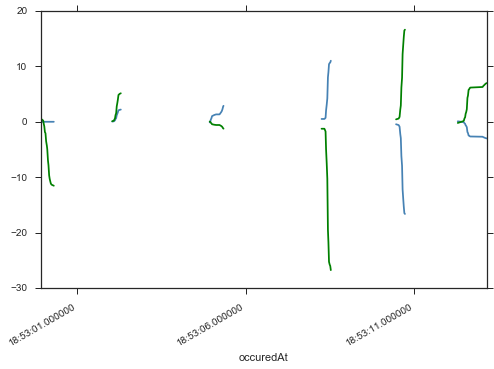

In [349]:
fig, ax = plt.subplots(1, 1)
test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='diffSum', ax=ax, legend=False, color='steelblue')
test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='otherDiffSum', ax=ax, legend=False, color='green')

question
0    Axes(0.125,0.2;0.775x0.7)
1    Axes(0.125,0.2;0.775x0.7)
2    Axes(0.125,0.2;0.775x0.7)
3    Axes(0.125,0.2;0.775x0.7)
4    Axes(0.125,0.2;0.775x0.7)
5    Axes(0.125,0.2;0.775x0.7)
dtype: object

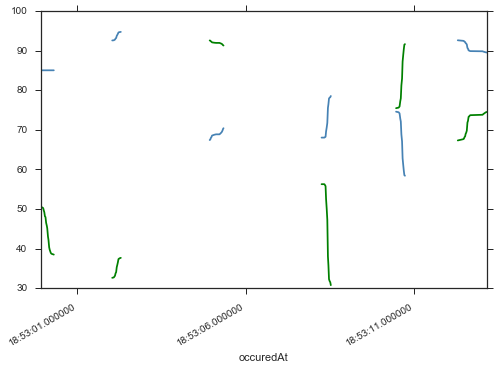

In [350]:
fig, ax = plt.subplots(1, 1)
test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='self', ax=ax, legend=False, color='steelblue')
test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='other', ax=ax, legend=False, color='green')

In [351]:
# for _id in sample_groups:
#     test = grouped.get_group(sample_groups[4])
#     fig, ax = plt.subplots(1, 1)
#     test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='diffSum', ax=ax, legend=False, color='steelblue')
#     test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='otherDiffSum', ax=ax, legend=False, color='green')